### 174 samples, Final_R is missing for the following sample, I put 0.8 to consider the sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline

import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)

# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
import pydot
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-08-18 18:20:25.039646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 18:20:25.039671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dropped = ['Mass', 'Init_R', 'Fin_R', 'Voltage', 'Res_Volt', 'PulseTime_I', 'I_Mean']
def import_file(filename):
    # Convert to pandas dataframe & take a look
    # filename='FJH_ML.csv'
    df = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
    # df = df.drop('Unnamed: 27', axis=1)
    # df = df.drop('Unnamed: 28', axis=1)
    # df = df.drop('Unnamed: 29', axis=1)
    df = df.dropna()
    # Convert numerical columns to float
    interest = ['Mass', 'Pretreat_voltage', 'Pretreat_highest', 'Voltage', 'PulseTime', 'Cap', 
                'Res_Volt', 'Init_R', 'Fin_R', 'Volt_Drop', 'Res_Drop', 'Yield_Per', 'I_Max', 
                'I_Mean', 'Charge_Tot', 'PulseTime_I', 'I_Final', 'Maxima', 'Graphene_Yield', 
                'TwoDtoG', 'DtoG', 'FWHM 2D']
    for i in range(0, len(interest)):
        col = interest[i]
        df[col] = df[col].astype(float)
    # Fix percentages
    df['Graphene_Yield'] = df['Graphene_Yield']*100
    df['Yield_Per'] = df['Yield_Per']*100
    
    
    
    # Drop problematic data for this particular analysis
    dropped_features = [ 'Res_Drop',
             'PulseTime_I', 'I_Mean', 'Maxima']
    df = df.drop(dropped_features, axis=1)
    
    
    
    # df = df[df['Yield_Per']>50]
    # Also drop asinine variables
    
    #df = df.drop('Map File ID', axis = 1)
    df = df.drop('Tube Diam', axis = 1)

    # categorize_yield(df)
    # One-hot encode the data using pandas get_dummies
    df = pd.get_dummies(df)
    # df = df[df['Material_CB']>0.5]
    # Drop 1 thing
    # df = df.drop['']
    # Dataset is now stored in a Pandas Dataframe
    # print(df.shape)
    # print(df.head())
    # print(df.isnull().sum())
    return df

def import_file_noOneHot(filename):
# Convert to pandas dataframe & take a look
    # filename='FJH_ML.csv'
    df = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
    # df = df.drop('Unnamed: 27', axis=1)
    # df = df.drop('Unnamed: 28', axis=1)
    # df = df.drop('Unnamed: 29', axis=1)
    df = df.dropna()
    # Convert numerical columns to float
    interest = ['Mass', 'Pretreat_voltage', 'Pretreat_highest', 'Voltage', 'PulseTime', 'Cap', 
                'Res_Volt', 'Init_R', 'Fin_R', 'Volt_Drop', 'Res_Drop', 'Yield_Per', 'I_Max', 
                'I_Mean', 'PulseTime_I', 'I_Final', 'Maxima', 'Graphene_Yield', 'TwoDtoG', 'DtoG', 'FWHM 2D']
    for i in range(0, len(interest)):
        col = interest[i]
        df[col] = df[col].astype(float)
    # Fix percentages
    df['Graphene_Yield'] = df['Graphene_Yield']*100
    df['Yield_Per'] = df['Yield_Per']*100
    # Drop problematic data for this particular analysis
    # df = df[df['Yield_Per']>50]
    # Also drop asinine variables
    try:
        df = df.drop('Map File ID', axis = 1)
    except:
        pass
    df = df.drop('Tube Diam', axis = 1)
    # categorize_yield(df)
    # One-hot encode the data using pandas get_dummies
    # df = pd.get_dummies(df)
    # df = df[df['Material_CB']>0.5]
    # Drop 1 thing
    # df = df.drop['']
    # Dataset is now stored in a Pandas Dataframe
    # print(df.shape)
    # print(df.head())
    # print(df.isnull().sum())
    return df

def categorize_yield(df):
    yield_cat = []
    for i in range(0, len(df)):
        if df['Graphene_Yield'][i] < 50:
            yield_cat.append(0)
        elif df['Graphene_Yield'][i] < 50 and df['TwoDtoG'][i] < 0.8:
            yield_cat.append(1)
        else:
            yield_cat.append(2)
    print(len(df))
    print(len(yield_cat))
    df['Yield_Cat'] = yield_cat
    
def leave_one_out_proc(clf):
    # Leave one out evaluation
    # enumerate splits
    y_true, y_pred = list(), list()
    # Create leave one out procedure
    cv = LeaveOneOut()
    for train_ix, test_ix in cv.split(features):
        # split data
        train_features, test_features = features[train_ix, :], features[test_ix, :]
        train_labels, test_labels = labels[train_ix], labels[test_ix]
        clf.fit(train_features, train_labels)
        # evaluate model
        yhat = clf.predict(test_features)
        # store
        y_true.append(test_labels[0])
        y_pred.append(yhat[0])
    print('doneskies')
    return y_true, y_pred, clf

def category_normalization_theonesyoualwaysuse(df):
    groups = df.groupby(['Material'])
    norm_I_Max = []
    norm_charge_tot=[]
    for name, group in groups:
        I_Max_array = np.asfarray(group.I_Max)
        charge_tot_array = np.asfarray(group.Charge_Tot)
        mean_I_Max = np.mean(I_Max_array)
        mean_charge_tot = np.mean(charge_tot_array)
        std_I_Max = np.std(I_Max_array)
        std_charge_tot = np.std(charge_tot_array)
        print("Mean of ", name, "is ", mean_I_Max)
        norm_I_Max_cat = np.divide(np.subtract(I_Max_array, mean_I_Max), std_I_Max)
        norm_charge_tot_cat = np.divide(np.subtract(charge_tot_array, mean_charge_tot), std_charge_tot)
        norm_I_Max = np.append(norm_I_Max, norm_I_Max_cat)
        norm_charge_tot = np.append(norm_charge_tot, norm_charge_tot_cat)
    return norm_I_Max, norm_charge_tot

def category_normalization_mass(df):
    groups = df.groupby(['Material'])
    norm_array = []
    for name, group in groups:
        yield_array = np.asfarray(group.Mass)
        mean_yield = np.mean(yield_array)
        std_yield = np.std(yield_array)
        print("Mean of ", name, "is ", mean_yield)
        norm_yield_cat = np.divide(np.subtract(yield_array, mean_yield), std_yield)
        norm_array = np.append(norm_array, norm_yield_cat)
    return norm_array

In [3]:
# Import file
# read the file with 174 samples:
filename='FJH_ML_Final174.csv'
df1 = import_file_noOneHot(filename)
Imax, chargetot = category_normalization_theonesyoualwaysuse(df1)
yield_array = category_normalization_mass(df1)
df = import_file(filename)
# df['Norm_I_Max'] = Imax
df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
# df['Discharge_Rate'] = (df['Volt_Drop']/df['Mass'])/df['PulseTime']
# df['norm_mass'] = yield_array
# df['cap_energy'] = 0.5*df['Voltage']*df['Voltage']*df['Cap']/df['Mass']
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
# df['charge_density2'] = df['Volt_Drop']*df['Cap']/df['Mass']
# df['RC'] = df['Init_R']*df['Cap']
# df['test_feature'] = 1/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']
# df['discharge_per'] = df['Res_Volt']/df['Voltage']
# df['Pretreat_CD'] = df['Pretreat_highest']*df['Cap']/df['Mass']
# df['inv_Mass'] = 1/df['Mass']
#df['average_res'] = (df['Init_R']+df['Fin_R'])/2
#df['Power'] = df['I_Max']*df['I_Max']*df['average_res']/df['Mass']
# df = df.drop('average_res', axis=1)
# df['test_feature'] = df['Res_Volt']/df['Voltage']
# df = df.drop('norm_mass', axis=1)
# Drop stuff
#df = df.drop('Voltage', axis=1)
#df = df.drop('Res_Volt', axis=1)
# df = df.drop('Norm_I_Max', axis=1)
#df = df.drop('Volt_Drop', axis=1)
#df = df.drop('Mass', axis=1)
#df = df.drop('Cap', axis=1)
#df = df.drop('PulseTime', axis=1)
#df = df.drop('I_Final', axis=1)
#df = df.drop('Fin_R', axis=1)
#df = df.drop('Init_R', axis=1)
#df = df.drop('Pretreat_highest', axis=1)
#df = df.drop('Pretreat_voltage', axis=1)

# Why he droped Material_PA and Material_TCB?
#df = df.drop('Material_PA', axis=1)
#df = df.drop('Material_TCB', axis=1)


# df = df.drop('Norm_charge_tot', axis=1)
#df = df.drop('Charge_Tot', axis=1)
# df = df.drop('Final_Current_Percent', axis=1)
# df = df.drop('charge_density', axis=1)
# df = df.drop('average_res', axis=1)""
#df['FJH_Power'] = df['I_Max']*df['I_Max']*df['Init_R']
# df = df[df['Graphene_Yield']>20]

# Print stats
print(df.shape)
print(df.head())
# print(len(df))
print(sum(df['Material_MC']))

Mean of  CB is  199.5962952631579
Mean of  MC is  546.874309090909
Mean of  PA is  301.9472116666666
Mean of  TCB is  217.5159437837838
Mean of  CB is  186.9859649122807
Mean of  MC is  274.92954545454546
Mean of  PA is  283.28055555555557
Mean of  TCB is  319.81081081081084
(174, 31)
   Sample   Mass  Pretreat_voltage  Pretreat_highest  Voltage  PulseTime  \
0       1  200.0              60.0              60.0    235.0     1200.0   
1       2  161.9             150.0              50.0    120.0       50.0   
2       3  200.0             240.0              60.0    235.0      300.0   
3       4  200.0             320.0              80.0    235.0      900.0   
4       5  187.0              60.0              60.0    145.0      125.0   

   Res_Volt    Cap  Init_R  Fin_R  ...  Material_MC  Material_PA  \
0      56.0   96.0     1.6    0.4  ...            0            0   
1      98.0  114.0     1.6    1.0  ...            0            0   
2     161.0   96.0     1.7    0.3  ...            0  

In [4]:
# proxy properties
Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

# only process parameters
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)
#Init_R = np.array (df['Init_R']).reshape(-1, 1)
#features = np.asfarray(features)

In [5]:
# type of material
Material_CB = np.array (df['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)
# extra material descriptors
# Cabot BP2000: Tensile Strength=17 MPa, particle size=15nm, specific surface area=1500(m2/g)
# metallurgical coke: grain size=150-210 (um)
# pyrolysis ash: 
# pyrolyzed rubber tire-derived carbon black: 

In [6]:
# type of Atmosphere
Atmosphere_air = np.array (df['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df['Atmosphere_arg']).reshape(-1, 1)
Atmosphere_vac = np.array (df['Atmosphere_vac']).reshape(-1, 1)

atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg, Atmosphere_vac), axis=1)

In [7]:
# proxy (current-time plot) prediction (Final_Current)
new_features = np.concatenate ((charge_denisty,
                                material_type,
                                atmosphere_type,
                                pulsetime,
                                Pretreat_voltage), axis=1)

rand=9
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, 
                                       indices, test_size = 0.20, random_state = rand)

In [8]:
r_squareds = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    clf_final_I_percent = XGBRegressor(max_depth=3, n_estimators=18, gamma=0.01, 
                   learning_rate=0.12, subsample=0.8, min_child_weight=6, 
                   random_state=random_state)
    # clf_final_I_percent = linear_model.BayesianRidge()
    # clf_final_I_percent = XGBRegressor()
    # Train the model on training data
    labels = Final_Current_Percent
    clf_final_I_percent.fit(train_new_features, train_labels);
    #print('Doneskies')
    Final_Current_Percent_test = clf_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
    r_squareds.append(r_squared_Final_Current_test)
    
    Final_Current_Percent_train = clf_final_I_percent.predict(train_new_features)
    r_squared_Final_Current_train = r2_score(train_labels, Final_Current_Percent_train)
    r_squareds_train.append(r_squared_Final_Current_train)    

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))


clf_final_I_percent.fit(new_features, labels)
# Use the forest's predict method on the test data
Final_Current_Percent_predicted = clf_final_I_percent.predict(new_features)
# Calculate the absolute errors
errors = abs(Final_Current_Percent_predicted - Final_Current_Percent)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Final_Current_all = r2_score(Final_Current_Percent, Final_Current_Percent_predicted)
print('r2 score = ', r_squared_Final_Current_all)

# Use the forest's predict method on the test data
Final_Current_Percent_test = clf_final_I_percent.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Final_Current_Percent_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
print('r2 score = ', r_squared_Final_Current_test)

Average of r_squared for test 0.6388605972230509
std of r_squared for test 0.01003459722503449 

Average of r_squared for train 0.7471645327414507
std of r_squared for train 0.012057115590536087
Mean Absolute Error: 0.2106 units.
r2 score =  0.7428260380922223
Mean Absolute Error: 0.2692 units.
r2 score =  0.7530370019994237


In [9]:
# proxy (current-time plot) prediction (Norm_I_Max)
new_features = np.concatenate ((charge_denisty, 
                                material_type,
                                atmosphere_type,
                                pulsetime,
                                Pretreat_voltage), axis=1)

rand=9
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = rand)

In [10]:
r_squareds = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    clf_norm_I_max = XGBRegressor(max_depth=2, n_estimators=24, gamma=0.001, 
                   learning_rate=0.116, subsample=0.75, min_child_weight=6, 
                  random_state=random_state)
    # clf_norm_I_max = linear_model.BayesianRidge()
    # clf_norm_I_max = XGBRegressor()
    # Train the model on training data
    labels = Norm_I_Max
    clf_norm_I_max.fit(train_new_features, train_labels);
    #print('Doneskies')
    Norm_I_Max_test = clf_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    r_squareds.append(r_squared_Norm_I_Max_test)
    
    Norm_I_Max_train = clf_norm_I_max.predict(train_new_features)
    r_squared_Norm_I_Max_train = r2_score(train_labels, Norm_I_Max_train)
    r_squareds_train.append(r_squared_Norm_I_Max_train)    

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))


clf_norm_I_max.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_I_Max_predicted = clf_norm_I_max.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_I_Max_predicted - Norm_I_Max)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_I_Max_all = r2_score(Norm_I_Max, Norm_I_Max_predicted)
print('r2 score = ', r_squared_Norm_I_Max_all)

# Use the forest's predict method on the test data
Norm_I_Max_test = clf_norm_I_max.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_I_Max_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
print('r2 score = ', r_squared_Norm_I_Max_test)

Average of r_squared for test 0.5868368086780266
std of r_squared for test 0.014059802469985224 

Average of r_squared for train 0.6993520371359733
std of r_squared for train 0.005164742662273347
Mean Absolute Error: 713.6396 units.
r2 score =  0.6857401531624816
Mean Absolute Error: 721.8532 units.
r2 score =  0.6557397798388631


In [11]:
# proxy (current-time plot) prediction (Norm_charge_tot)
new_features = np.concatenate ((charge_denisty, 
                                material_type,
                                atmosphere_type,
                                pulsetime,
                                Pretreat_voltage), axis=1)
rand=9
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = rand)

In [12]:
r_squareds = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(50):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    clf_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=21, gamma=0.01, 
                   learning_rate=0.116, subsample=0.75, min_child_weight=4, 
                  random_state=random_state)
    # clf_norm_charge_total = linear_model.BayesianRidge()
    # clf_norm_charge_total = XGBRegressor()
    # Train the model on training data
    labels = Norm_charge_tot
    clf_norm_charge_total.fit(train_new_features, train_labels);
    #print('Doneskies')
    Norm_charge_tot_test = clf_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    r_squareds.append(r_squared_Norm_charge_tot_test)
    
    Norm_charge_tot_train = clf_norm_charge_total.predict(train_new_features)
    r_squared_Norm_charge_tot_train = r2_score(train_labels, Norm_charge_tot_train)
    r_squareds_train.append(r_squared_Norm_charge_tot_train)    

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))


clf_norm_charge_total.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_charge_tot_predicted = clf_norm_charge_total.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_charge_tot_predicted - Norm_charge_tot)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_charge_tot_all = r2_score(Norm_charge_tot, Norm_charge_tot_predicted)
print('r2 score = ', r_squared_Norm_charge_tot_all)

# Use the forest's predict method on the test data
Norm_charge_tot_test = clf_norm_charge_total.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_charge_tot_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
print('r2 score = ', r_squared_Norm_charge_tot_test)

Average of r_squared for test 0.5825120155246001
std of r_squared for test 0.03182987030382326 

Average of r_squared for train 0.7167985727783308
std of r_squared for train 0.008912122777172923
Mean Absolute Error: 30.1311 units.
r2 score =  0.7246296913235304
Mean Absolute Error: 33.3868 units.
r2 score =  0.8172120038834974


In [13]:
# Porxy properties, as well as process parameters
new_features = np.concatenate ((charge_denisty, 
                                material_type, 
                                pulsetime,
                                Pretreat_voltage,
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1)), axis=1)

rand=9
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.20, random_state = rand)

In [14]:
r_squareds = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(100):
    # Instantiate model with 1000 decision trees
    clf = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.01, 
                   learning_rate=0.1155, subsample=0.81, min_child_weight=5, 
                   random_state=random_state)
    # Train the model on training data
    clf.fit(train_new_features, train_labels);
    # Use the forest's predict method on the test data
    predictions = clf.predict(test_new_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    MAEs.append(errors)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

    r_squared = r2_score(test_labels, predictions)
    r_squareds.append (r_squared)
    
    pred_train = clf.predict(train_new_features)
    errors = abs(pred_train - train_labels)
    MAEs_train.append(errors)
    r_squared = r2_score(train_labels, pred_train)
    r_squareds_train.append(r_squared)
    #print('r2 score = ', r_squared)

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))
# train accuracy
pred_train = clf.predict(train_new_features)
# Calculate the absolute errors
errors_train = abs(pred_train - train_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')

r_squared_train = r2_score(train_labels, pred_train)
print('r2 score = ', r_squared_train)
end = time.time()
print ('time is: ', end-start)

Average of r_squared for test 0.7173060061609462
std of r_squared for test 0.0151919463915653 

Average of r_squared for train 0.798604398079405
std of r_squared for train 0.004448128350946068
Mean Absolute Error: 27.5935 units.
r2 score =  0.7941558872169956
time is:  7.6813085079193115


In [15]:
np.array (df['Mass'])

array([200. , 161.9, 200. , 200. , 187. , 200. , 178. , 300. , 300. ,
       182. , 300. , 300. , 118. , 130. , 189. , 200. , 182. , 230. ,
       260. , 200. , 200. , 200. , 150. , 150. , 150. , 200. , 223.3,
       208. , 150. , 200. , 223.5, 200. , 113. , 153.9, 193. , 122. ,
       156.3, 144. , 235. , 146.8, 200. , 156. , 134.7, 168. , 200. ,
       155. , 236.2, 158. , 209.6, 102. , 165. , 146. , 199. , 152. ,
       141. , 199. , 200. , 267. , 240.8, 220.5, 337. , 372. , 291. ,
       275. , 221. , 262. , 183. , 217. , 284. , 272. , 242. , 319. ,
       257. , 235. , 266. , 261. , 309. , 286. , 312.9, 205.7, 355.4,
       305.6, 346.6, 214.7, 378.7, 311.5, 342. , 230. , 257. , 204. ,
       293. , 227. , 204. , 391. , 223.4, 257.2, 297. , 354. , 358. ,
       257. , 302. , 237. , 313. , 222. , 233. , 269. , 270. , 292. ,
       267. , 277. , 273. , 348. , 310. , 245. , 212. , 321. , 302. ,
       268. , 288. , 303. , 339. , 304. , 271. , 273. , 283. , 246. ,
       282. , 261. ,

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


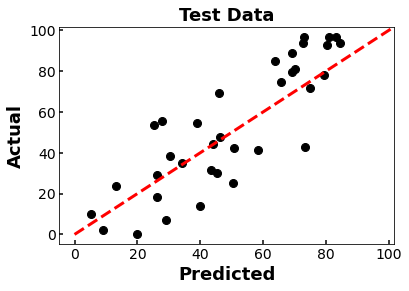

In [16]:
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
# ax.set_xlim(20,105)
# ax.set_ylim(20,105)

# Predicted 2D/G
plt.plot(predictions, test_labels, linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Predicted', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Actual', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

Pearsons correlation: 0.23772359849411392


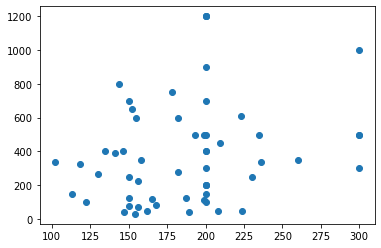

In [17]:
# Mass and pulse time are not linearly related. 
# But, mat be if one fix material, can find a relation
mass_cb = np.array (df['Mass'][df1['Material']=='CB'])
pulse_time_cb = np.array(df['PulseTime'][df1['Material']=='CB'])
plt.scatter(mass_cb, pulse_time_cb)

corr, _ = pearsonr(mass_cb, pulse_time_cb)
print('Pearsons correlation:', corr)


In [18]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

NameError: name 'feature_list' is not defined

In [ ]:
# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Import file
filename='FJH_ML_Final.csv'
df = import_file_noOneHot(filename)
# Create normalized I by category
norm1, norm2 = category_normalization_theonesyoualwaysuse(df)
df['Norm_I_Max'] = norm1
df['Norm_charge_tot'] = norm2
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
# df['test_feature'] = (df['Voltage']/df['Mass'])#*df['PulseTime']
# df = df[df['TwoDtoG']<1.5]
# df = df[df['Graphene_Yield']>20]

# Cut dataframe to only the test set
df = df.iloc[idx_train]
df['y_pred'] = y_pred
df['y_true'] = y_true

groups = df.groupby(['Material'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df['I_Max'],df['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformanceJune25.png', dpi=300)
plt.show()

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
for name, group in groups:
    p = ax.scatter(group.y_pred, group.y_true, c=group.charge_density, marker='o', s=100, cmap='Blues')
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('Charge Density (C/g)', fontsize='18', fontname='Arial', fontweight='bold')
cb.ax.tick_params(labelsize=14)

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
# ax.legend(fontsize=12)

# Plot
# plt.plot(df['I_Max'],df['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
# plt.savefig('XGB_Regression_Performance_colorChargeDensity.png', dpi=300)
plt.show()

In [ ]:
# Train neural network
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator=MLPRegressor(),
        param_grid={'hidden_layer_sizes': [(100, 100, 100), (10,10,10), (50,50,50), (200, 200, 200)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.05, 0.10, 0.12, 0.15],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam'],
          'n_iter_no_change': range(3,7)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('hidden layer: ', best_params["hidden_layer_sizes"])
print('activation: ', best_params["activation"])
print('learning_rate: ', best_params["learning_rate"])
print('solver ', best_params["solver"])
print('alpha ', best_params["alpha"])
print('N_iter_no_change ', best_params["n_iter_no_change"])

In [ ]:
#M2 Multilayer Perceptron
model = 'M2 MLP'
print(model)
def build_mlp(units = 20, optimizer = 'rmsprop'):
    mlp = Sequential()
    mlp.add(Dense(units = units, activation = 'relu', input_dim = features.shape[1]))
    mlp.add(Dense(units = units, activation = 'relu', ))
    mlp.add(Dense(units = 1))
    mlp.compile(optimizer = optimizer, 
                loss='mean_squared_error', 
                metrics = ['mae'])
    return mlp
mlp = KerasRegressor(build_fn = build_mlp, verbose = 0)
grid_param_mlp = {'units': [20, 40, 60],
                    'batch_size': [16, 32, 64, 128],
                    'epochs': [100, 500, 1000],
                    'optimizer': ['rmsprop', 'adam']}
grid_param_mlp = {'units': [20],
                    'batch_size': [ 128],
                    'epochs': [100],
                    'optimizer': ['adam']}
grid_mlp = GridSearchCV(mlp, grid_param_mlp) 
grid_mlp.fit(train_features, train_labels)
y_pred_train_mlp = grid_mlp.predict(train_features)
y_pred_test_mlp = grid_mlp.predict(test_features)
#df_eval_mlp = save_evaluate_draw(y_pred_train_mlp, y_pred_test_mlp, 
#                                grid_param_mlp, grid_mlp.best_params_, 
#                                grid_mlp.best_estimator_, model)

print('Doneskies')


In [ ]:
feature_names = ['CB SM', 'MC SM', 'A$\mathregular{_{IT}}$', 'I$\mathregular{_{Max}}$', 'CD', 'I$\mathregular{_{f}}$/I$\mathregular{_{Max}}$']
pdp = partial_dependence(clf, features, (5,4))
print('Done!')

In [ ]:
# 3,4 then 2,4 then 2,3 then 5,4
# 4 is CD, 3 is Imax, 2 is AIT, 5 is If/Imax

X=pdp[1][0]
Y=pdp[1][1]
Z=pdp[0][0]
X, Y = np.mgrid[0:X:100j, 0:Y:100j]

resultX = ndimage.zoom(X, 10.0)
resultY = ndimage.zoom(Y, 10.0)
resultZ = ndimage.zoom(Z, 10.0)

fig, ax2 = plt.subplots(figsize=(10,8))
ax2 = plt.axes(projection='3d')
ax2.plot_surface(resultX, resultY, resultZ, rstride=1, cstride=1, cmap='Oranges', alpha=0.7, shade=False, antialiased=True)
plt.show()

In [ ]:
X=pdp[1][0]
Y=pdp[1][1]
Z=pdp[0][0]

In [ ]:
X

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(figsize=(9,7))
ax = plt.axes(projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0, labelsize=16)

# Now set color to white (or whatever is "invisible")
# ax.xaxis.pane.set_edgecolor('w')
# ax.yaxis.pane.set_edgecolor('w')
# ax.zaxis.pane.set_edgecolor('w')
# Bonus: To get rid of the grid as well:
# ax.grid(False)
ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0, labelsize=20)

cset = ax.contourf(resultX, resultY, resultZ, zdir='z', offset=np.min(Z), cmap='Greens')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=0, cmap='Oranges')
# cset = ax.contourf(X, Y, Z, zdir='y', offset=165, cmap='Oranges')
# print(Z)

surf = ax.plot_surface(resultX, resultY, resultZ, rstride=1, cstride=1, cmap='Greens', alpha=0.7, shade=False, antialiased=True)
cb = fig.colorbar(surf, shrink=0.5, aspect=8)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)

ax.set_xlabel('\n\nI$\mathregular{_{F}}$/I$\mathregular{_{Max}}$ (a.u.)', fontfamily='Arial', fontweight='bold', fontsize=28, linespacing=3)
# ax.set_xlabel('\nA$\mathregular{_{IT}}$ (C/g)', fontfamily='Arial', fontweight='bold', fontsize=28)
# ax.set_xlabel('\nI$\mathregular{_{Max}}$ (A/g)', fontfamily='Arial', fontweight='bold', fontsize=28)
ax.set_ylabel('\n\nCD (C/g)', fontfamily='Arial', fontweight='bold', fontsize=28, linespacing=3)
ax.set_zlabel('\nPD (%)', fontfamily='Arial', fontweight='bold', fontsize=28, linespacing=3)
# ax.view_init(30, -150)

ax.set_yticks([0, 30, 60, 90, 120, 150])

plt.savefig('3Dplot4_IfImax_CD_PD.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(len(errors))

print(errors)

In [ ]:
# plot single tree
plot_tree(clf, num_trees=5, rankdir='LR')
plt.savefig('XGBtree.png', dpi=300)
plt.show()

In [ ]:

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = clf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree2.dot', feature_names = feature_list, rounded = True, precision = 1)

In [ ]:
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree2.dot')
# Write graph to a png file
graph.write_png('sampleTree.png')

In [ ]:
import matplotlib.pyplot as plt

x = 100
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
features2 = ['CB', 'TCB', 
             'PA', 'MC']
importances2 = [32.9/x, 21.4/x, 20.8/x, 24.9/x]
colors = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
explode = (0, 0.0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='16')
ax1.pie(importances2, explode=explode, labels=features2, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Format and save
plt.tight_layout()
plt.savefig('Materialmetrics.png', dpi=300) # Change file name